## CS441: Applied ML - HW 3

# Part 1: CLIP: Contrastive Language-Image Pretraining
Include all the code for Part 1 in this section

### 1.1 Prepare data

[Here](https://drive.google.com/file/d/1zJ1KfymSfsbmD6QS-F0eUC8T1PkqW0_j/view?usp=sharing) is the json file you need for labels of flowers 102

In [ ]:
import json
import os
import os.path as osp
import numpy as np
from google.colab import drive
import torch
from torchvision.datasets import Flowers102
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
drive.mount('/content/drive')
# datadir = "/content/drive/My Drive/Spring2023/cs441/hw3/"
datadir = "."

Mounted at /content/drive


In [ ]:
def load_flower_data(img_transform=None):
    if os.path.isdir(datadir+ "flowers-102"):
      do_download = False
    else:
      do_download = True
    train_set = Flowers102(root=datadir, split='train', transform=img_transform, download=do_download)
    test_set = Flowers102(root=datadir, split='val', transform=img_transform, download=do_download)
    classes = json.load(open(osp.join(datadir, "flowers102_classes.json")))

    return train_set, test_set, classes

### 1.2 Prepare CLIP model

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-njx26u5y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-njx26u5y
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=10d1a61c3309286a71d4c8616c11aa50adc9dbab6563195432e3e222f87bbf3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-bztzv3_c/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [ ]:
import clip

In [ ]:
# Sets device to "cuda" if a GPU is available
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)
# If this takes a really long time, stop and then restart the download
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

cuda


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 107MiB/s]


### 1.3 CLIP zero-shot prediction

Ground truth: giant white arum lily

Top predictions:

giant white arum lily: 60.01%
           lotus: 12.98%
      siam tulip: 8.25%
       anthurium: 3.55%
   morning glory: 1.87%


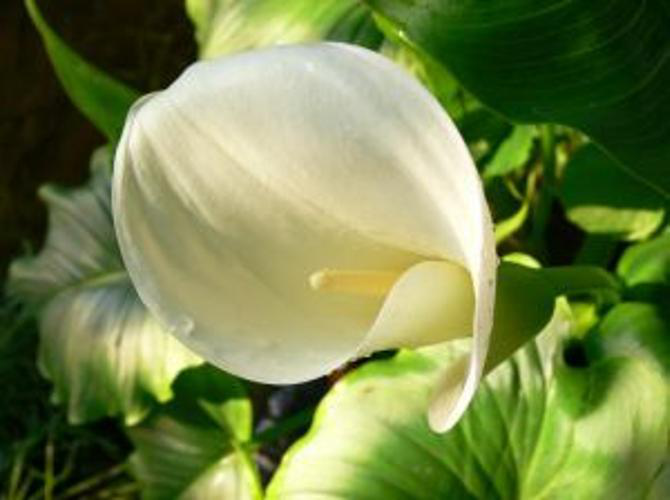

In [ ]:
"""The following is an example of using CLIP pre-trained model for zero-shot prediction task"""
# Prepare the inputs
n = 200
image, class_id = flower_train[n]
image_input = clip_preprocess(image).unsqueeze(0).to(device) # extract image and put in device memory
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in flower_classes]).to(device) # put text to match to image in device memory

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input) # compute image features with CLIP model
    text_features = clip_model.encode_text(text_inputs) # compute text features with CLIP model
image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

# Pick the top 5 most similar labels for the image
similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
p_class_given_image= similarity.softmax(dim=-1)  # P(y|x) is score through softmax
values, indices = p_class_given_image[0].topk(5) # gets the top 5 labels

# Print the probability of the top five labels
# print("Ground truth:", flower_classes[class_id])
# print("\nTop predictions:\n")
# for value, index in zip(values, indices):
#     print(f"{flower_classes[index]:>16s}: {100 * value.item():.2f}%")
# image

### 1.4 YOUR TASK: Test CLIP zero-shot performance on Flowers 102

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
# Load flowers dataset again. This time, with clip_preprocess as transform
flower_train_trans, flower_test_trans, flower_classes = load_flower_data(img_transform=clip_preprocess)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

In [ ]:
def clip_zero_shot(data_set, classes):
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)  # dataloader lets you process in batch which is way faster
    # Needs code here
    # Prepare the inputs
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in classes]).to(device)

    # Calculate text features
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)

        # Calculate image features
        with torch.no_grad():
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate similarities
        similarity = (100.0 * image_features @ text_features.T)
        p_class_given_image = similarity.softmax(dim=-1)

        # Get top predictions
        values, indices = p_class_given_image.topk(1)

        # Calculate accuracy
        correct += torch.sum(indices.squeeze() == labels.to(device)).item()
        total += labels.shape[0]

    accuracy = correct / total
    return accuracy

In [ ]:
accuracy = clip_zero_shot(data_set=flower_test_trans, classes=flower_classes)
print(f"\nAccuracy = {100*accuracy:.3f}%")


Accuracy = 67.941%


### 1.5 YOUR TASK: Test CLIP linear probe performance on Flowers 102

In [ ]:
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader

In [ ]:
"""
In this part, train a linear classifier on CLIP features
return: image features, labels in numpy format.
"""
def get_features(data_set):
    # Needs code here
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)  # dataloader lets you process in batch which is way faster
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
          features =  clip_model.encode_image(images.to(device))

          all_features.append(features)
          all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [ ]:
# Calculate the image features
train_features, train_labels = get_features(flower_train_trans)
test_features, test_labels = get_features(flower_test_trans)

# Perform logistic regression
# Needs code here
clf = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1).fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
# Needs code here
accuracy = clf.score(test_features, test_labels)
print(f"\nAccuracy = {100*accuracy:.3f}%")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Accuracy = 93.627%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


### 1.6 YOUR TASK: Evaluate a nearest-neighbor classifier on CLIP features

In [ ]:
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def knn(x_train, y_train, x_test, y_test, K):
    # Needs code here
    clf = KNeighborsClassifier(n_neighbors = K).fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
# Calculate the image features
train_features, train_labels = get_features(flower_train_trans)
test_features, test_labels = get_features(flower_test_trans)

K_num = [1, 3, 5, 11, 21]

for K in K_num:
  accuracy = knn(train_features, train_labels, test_features, test_labels, K)
  print(f"\nAccuracy in K={K} = {100*accuracy:.3f}%")


Accuracy in K=1 = 84.118%

Accuracy in K=3 = 83.137%

Accuracy in K=5 = 84.510%

Accuracy in K=11 = 85.098%

Accuracy in K=21 = 79.804%


# Part 2: Fine-Tune for Pets Image Classification
Include all the code for Part 2 in this section

## 2.1 Prepare Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [ ]:
# Mount and define data dir
from google.colab import drive
drive.mount('/content/drive')
datadir = "." 
save_dir = "/content/drive/My Drive/cs441" 

Mounted at /content/drive


In [ ]:
def load_pet_dataset(train_transform = None, test_transform = None):
    OxfordIIITPet = datasets.OxfordIIITPet
    if os.path.isdir(datadir+ "oxford-iiit-pet"):
      do_download = False
    else:
      do_download = True
    training_set = OxfordIIITPet(root = datadir, 
                             split = 'trainval',
                             transform = train_transform, 
                             download = do_download)

    test_set = OxfordIIITPet(root = datadir,
                           split = 'test',
                           transform = test_transform, 
                           download = do_download)   
    return training_set, test_set
  

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet
Label: Abyssinian


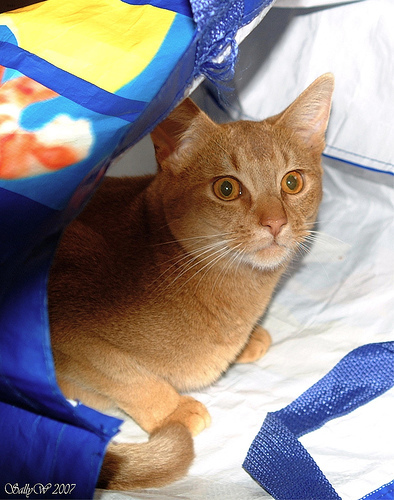

In [ ]:
train_set, test_set = load_pet_dataset()

# Display a sample in OxfordIIIPet dataset
sample_idx = 0 # Choose an image index that you want to display
print("Label:", train_set.classes[train_set[sample_idx][1]])
train_set[sample_idx][0]

## 2.2 Data Preprocess

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# Feel free to add augmentation choices 

# Apply data augmentation
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([  
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

In [ ]:
# Feel free to change 
train_set, test_set = load_pet_dataset(train_transform, test_transform)
train_loader = DataLoader(dataset=train_set,
                          batch_size=64, #64
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_set,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)


  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


## 2.3 Helper Functions



In [ ]:
# Display the number of parameters and model structure
def display_model(model):
  # Check number of parameters 
  summary_dict = {}
  num_params = 0
  summary_str = ['='*80]

  for module_name, module in model.named_children():
      summary_count = 0
      for name, param in module.named_parameters():
          if(param.requires_grad):
              summary_count += param.numel()
              num_params += param.numel()
      summary_dict[module_name] = [summary_count]
      summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

  summary_dict['total'] = [num_params]

  # print summary string
  summary_str += ['='*80]
  summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
  print('\n'.join(summary_str))

  # print model structure
  print(model)

In [ ]:
# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

## 2.4 YOUR TASK: Fine-Tune Pre-trained Network on Pets
Read and understand the code and then uncomment it.  Then, set up your learning rate, learning scheduler, and train/evaluate. Adjust as necessary to reach target performance.



In [ ]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
        output = model(images)
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)
    
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
        
    return mean_accuracy, test_loss    

In [ ]:
device = 'cuda'
# loads a pre-trained ResNet-34 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True) 
target_class = 37
# TO DO: replace the last layer with a new linear layer for Pets classification
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, target_class)

for param in model.fc.parameters():
    param.requires_grad = True
# model.fc = nn.Linear(512, target_class)

model = model.to(device)
display_model(model) # displays the model structure and parameter count

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

- conv1                                    :                 0                 
- bn1                                      :                 0                 
- relu                                     :                 0                 
- maxpool                                  :                 0                 
- layer1                                   :                 0                 
- layer2                                   :                 0                 
- layer3                                   :                 0                 
- layer4                                   :                 0                 
- avgpool                                  :                 0                 
- fc                                       :               18981               
--Total                                    :            18981 params           --
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(6

In [ ]:
# Training Setting. Feel free to change.
num_epochs = 20
test_interval = 5

# TO DO: set initial learning rate
learn_rate = 0.003 #64, 0.0003 0.001 best X-0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# TO DO: define your learning rate scheduler, e.g. StepLR 
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
lr_scheduler = lrs.StepLR(optimizer, step_size=3, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []


# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1): 
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    lr_scheduler.step() 
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')
    
    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

        # Checkpoints are used to save the model with best validation accuracy
        if test_accuracy >= max(test_accuracy_list):
          print("Saving Model")
          save_checkpoint(save_dir, model, save_name = 'best_model.pth') # Save model with best performance



loss: 0.611: 100%|██████████| 58/58 [00:33<00:00,  1.73it/s]


Loss for Training on epoch 0 is 1.2205781936645508 

Evaluating Network


Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.04it/s]

Mean Accuracy: 0.8853
Avg loss: 0.39642148310768194
Training accuracy on epoch 0 is 0.8853260869565217 




Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.01it/s]


Mean Accuracy: 0.8474
Avg loss: 0.5010737133180273
Testing accuracy on epoch 0 is 0.8473698555464704 

Saving Model



loss: 0.370: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]

Loss for Training on epoch 1 is 0.33469587564468384 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.08it/s]

Mean Accuracy: 0.9481
Avg loss: 0.21056889331546322
Training accuracy on epoch 1 is 0.9480978260869565 




Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.01it/s]


Mean Accuracy: 0.8893
Avg loss: 0.3604665658083455
Testing accuracy on epoch 1 is 0.8893431452711911 

Saving Model



loss: 0.309: 100%|██████████| 58/58 [00:28<00:00,  2.01it/s]

Training ...:  15%|█▌        | 3/20 [03:27<17:22, 61.35s/it]

Loss for Training on epoch 2 is 0.22592037916183472 



loss: 0.175: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Training ...:  20%|██        | 4/20 [03:55<12:53, 48.37s/it]

Loss for Training on epoch 3 is 0.1593143492937088 



loss: 0.070: 100%|██████████| 58/58 [00:28<00:00,  2.04it/s]

Training ...:  25%|██▌       | 5/20 [04:24<10:18, 41.22s/it]

Loss for Training on epoch 4 is 0.15160726010799408 



loss: 0.219: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Loss for Training on epoch 5 is 0.15119588375091553 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]

Mean Accuracy: 0.9785
Avg loss: 0.12074817222510946
Training accuracy on epoch 5 is 0.9785326086956522 




Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.07it/s]


Mean Accuracy: 0.9090
Avg loss: 0.30534996705707806
Testing accuracy on epoch 5 is 0.9089670209866448 

Saving Model



loss: 0.161: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]

Training ...:  35%|███▌      | 7/20 [06:16<10:06, 46.65s/it]

Loss for Training on epoch 6 is 0.13754452764987946 



loss: 0.113: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Training ...:  40%|████      | 8/20 [06:44<08:10, 40.86s/it]

Loss for Training on epoch 7 is 0.13986290991306305 



loss: 0.233: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Training ...:  45%|████▌     | 9/20 [07:12<06:46, 36.95s/it]

Loss for Training on epoch 8 is 0.14320234954357147 



loss: 0.112: 100%|██████████| 58/58 [00:28<00:00,  2.03it/s]

Training ...:  50%|█████     | 10/20 [07:41<05:43, 34.38s/it]

Loss for Training on epoch 9 is 0.14190265536308289 



loss: 0.101: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Loss for Training on epoch 10 is 0.13418146967887878 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.09it/s]

Mean Accuracy: 0.9793
Avg loss: 0.1180915249318912
Training accuracy on epoch 10 is 0.9793478260869565 




Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.01it/s]


Mean Accuracy: 0.9101
Avg loss: 0.302085000764707
Testing accuracy on epoch 10 is 0.9100572363041701 

Saving Model



loss: 0.088: 100%|██████████| 58/58 [00:28<00:00,  2.03it/s]

Training ...:  60%|██████    | 12/20 [09:35<05:48, 43.53s/it]

Loss for Training on epoch 11 is 0.13740713894367218 



loss: 0.142: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Training ...:  65%|██████▌   | 13/20 [10:04<04:32, 38.92s/it]

Loss for Training on epoch 12 is 0.1369641125202179 



loss: 0.244: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]

Training ...:  70%|███████   | 14/20 [10:32<03:34, 35.70s/it]

Loss for Training on epoch 13 is 0.14044202864170074 



loss: 0.161: 100%|██████████| 58/58 [00:27<00:00,  2.11it/s]

Training ...:  75%|███████▌  | 15/20 [10:59<02:46, 33.28s/it]

Loss for Training on epoch 14 is 0.13729631900787354 



loss: 0.156: 100%|██████████| 58/58 [00:26<00:00,  2.17it/s]

Loss for Training on epoch 15 is 0.14096397161483765 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:26<00:00,  2.16it/s]

Mean Accuracy: 0.9783
Avg loss: 0.11979530995775914
Training accuracy on epoch 15 is 0.9782608695652174 




Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.03it/s]

Training ...:  80%|████████  | 16/20 [12:22<03:12, 48.09s/it]

Mean Accuracy: 0.9071
Avg loss: 0.30398952206275587
Testing accuracy on epoch 15 is 0.9070591441809758 



loss: 0.168: 100%|██████████| 58/58 [00:28<00:00,  2.04it/s]

Training ...:  85%|████████▌ | 17/20 [12:50<02:06, 42.19s/it]

Loss for Training on epoch 16 is 0.13824398815631866 



loss: 0.137: 100%|██████████| 58/58 [00:28<00:00,  2.07it/s]

Training ...:  90%|█████████ | 18/20 [13:19<01:15, 37.97s/it]

Loss for Training on epoch 17 is 0.13767275214195251 



loss: 0.111: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]

Training ...:  95%|█████████▌| 19/20 [13:47<00:35, 35.06s/it]

Loss for Training on epoch 18 is 0.13546940684318542 



loss: 0.121: 100%|██████████| 58/58 [00:28<00:00,  2.05it/s]

Loss for Training on epoch 19 is 0.1390227973461151 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]

Mean Accuracy: 0.9799
Avg loss: 0.11840411378391857
Training accuracy on epoch 19 is 0.9798913043478261 




Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.03it/s]

Training ...: 100%|██████████| 20/20 [15:12<00:00, 45.63s/it]

Mean Accuracy: 0.9087
Avg loss: 0.3058029364409118
Testing accuracy on epoch 19 is 0.9086944671572635 



## 2.5 Plotting of losses and accuracy

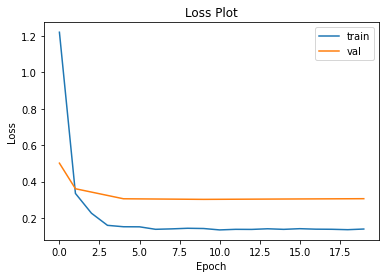

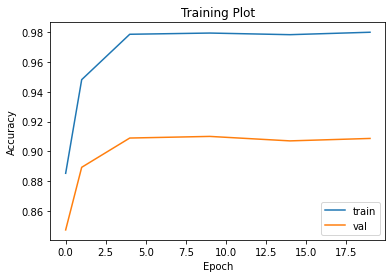

In [ ]:
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

## 2.6 Evaluating trained model

In [ ]:
# TO DO: initialize your trained model as you did before so that you can load the parameters into it
# device = 'cuda'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True).to(device) 
# replace last layer
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, target_class)

for param in model.fc.parameters():
    param.requires_grad = True

load_model(model, save_dir) # Load the trained weight
model = model.to(device)

test_accuracy, test_loss= test(test_loader, model, criterion)
print(f"Testing accuracy is {str(test_accuracy)} \n")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.03it/s]

Mean Accuracy: 0.9101
Avg loss: 0.302085000764707
Testing accuracy is 0.9100572363041701 



## Part 3: No coding for this part

# Part 4: Stretch Goals
Include any new code needed for Part 3 here

## 4.1 Compare word tokenizers

In [1]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.3 MB/s eta 0:00:00


In [2]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip
!unzip wikitext-2-raw-v1.zip

--2023-03-28 20:05:18--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.161.8, 52.217.17.230, 52.217.135.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.161.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4721645 (4.5M) [application/zip]
Saving to: ‘wikitext-2-raw-v1.zip’

wikitext-2-raw-v1.z 100%[===================>]   4.50M  6.58MB/s    in 0.7s    

2023-03-28 20:05:19 (6.58 MB/s) - ‘wikitext-2-raw-v1.zip’ saved [4721645/4721645]

Archive:  wikitext-2-raw-v1.zip
   creating: wikitext-2-raw/
  inflating: wikitext-2-raw/wiki.test.raw  
  inflating: wikitext-2-raw/wiki.valid.raw  
  inflating: wikitext-2-raw/wiki.train.raw  


In [3]:
from tokenizers import Tokenizer
from tokenizers.models import BPE, Unigram #, WordLevel, WordPiece
from tokenizers.trainers import BpeTrainer, UnigramTrainer 
from tokenizers.pre_tokenizers import Whitespace, BertPreTokenizer

unk_token = "[UNK]"  # token for unknown words
spl_tokens = ["[UNK]", "[SEP]", "[MASK]", "[CLS]", "[PAD]"]  # special tokens

files = [f"./wikitext-2-raw/wiki.{split}.raw" for split in ["train", "valid", "test"]]
# input_string = "I am the fastest planet"
strings = ["I am learning about word tokenizers. They are not very complicated, and they are a good way to convert natural text into tokens.", "If, for example, you came at four o’clock in the afternoon, then at three o’clock I shall begin to be happy."]

tokens_dict = {}

for input_string in strings:
  for alg in ['BPE', 'UNI']:
      if alg == 'BPE':
          tokenizer = Tokenizer(BPE(unk_token=unk_token))
          trainer = BpeTrainer(special_tokens=spl_tokens)
      elif alg == 'UNI':
          tokenizer = Tokenizer(Unigram())
          trainer = UnigramTrainer(special_tokens = spl_tokens)

      tokenizer.pre_tokenizer = Whitespace()

      tokenizer.train(files=files, trainer=trainer)

      output = tokenizer.encode(input_string)

      tokens = output.tokens

      tokens_dict[alg] = tokens
      print(f"---- {alg} ----")
      print(tokens_dict[alg])


---- BPE ----
['I', 'am', 'learning', 'about', 'word', 'to', 'ken', 'izers', '.', 'They', 'are', 'not', 'very', 'complicated', ',', 'and', 'they', 'are', 'a', 'good', 'way', 'to', 'convert', 'natural', 'text', 'into', 'to', 'k', 'ens', '.']
---- UNI ----
['I', 'am', 'learn', 'ing', 'about', 'word', 'to', 'k', 'en', 'ize', 'r', 's', '.', 'They', 'are', 'not', 'very', 'complicate', 'd', ',', 'and', 'the', 'y', 'are', 'a', 'good', 'way', 'to', 'convert', 'natural', 'text', 'into', 'to', 'k', 'en', 's', '.']
---- BPE ----
['If', ',', 'for', 'example', ',', 'you', 'came', 'at', 'four', 'o', '’', 'clock', 'in', 'the', 'afternoon', ',', 'then', 'at', 'three', 'o', '’', 'clock', 'I', 'shall', 'begin', 'to', 'be', 'happy', '.']
---- UNI ----
['I', 'f', ',', 'for', 'example', ',', 'you', 'came', 'at', 'four', 'o', '’', 'clock', 'in', 'the', 'afternoon', ',', 'the', 'n', 'at', 'three', 'o', '’', 'clock', 'I', 's', 'hall', 'begin', 'to', 'be', 'happ', 'y', '.']


## 4.2 Implement your own network

In [ ]:
# example network definition that needs to be modified for custom network stretch goal

class Network(nn.Module):
    def __init__(self, num_classes=10, dropout = 0.5):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )


    def forward(self, x):
        N, c, H, W = x.shape
        features = self.features(x)
        pooled_features = self.avgpool(features)
        output = self.classifier(torch.flatten(pooled_features, 1))
        return output